<a href="https://colab.research.google.com/github/RunTimeError02/D49_DeepLearningLab-1/blob/main/D49_SagarDave_DL_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name:** Sagar Rajendra Dave <br>
**Roll Number:** D4_49 <br>
**Course Name:** Deep Learning-I Lab Project <br>
<br>

**About Dataset:** <br>
Category: <br>
1. point-like corneal ulcers.<br>
2. point-flaky mixed corneal ulcers.<br>
3. flaky corneal ulcers.<br>

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d bongsang/eye-disease-deep-learning-dataset

eye-disease-deep-learning-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/eye-disease-deep-learning-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


#### **Preprocessing of the Dataset**

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 712 files belonging to 1 classes.


In [ ]:
class_names = dataset.class_names
class_names

['images']

In [ ]:
len(dataset)

23

In [ ]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


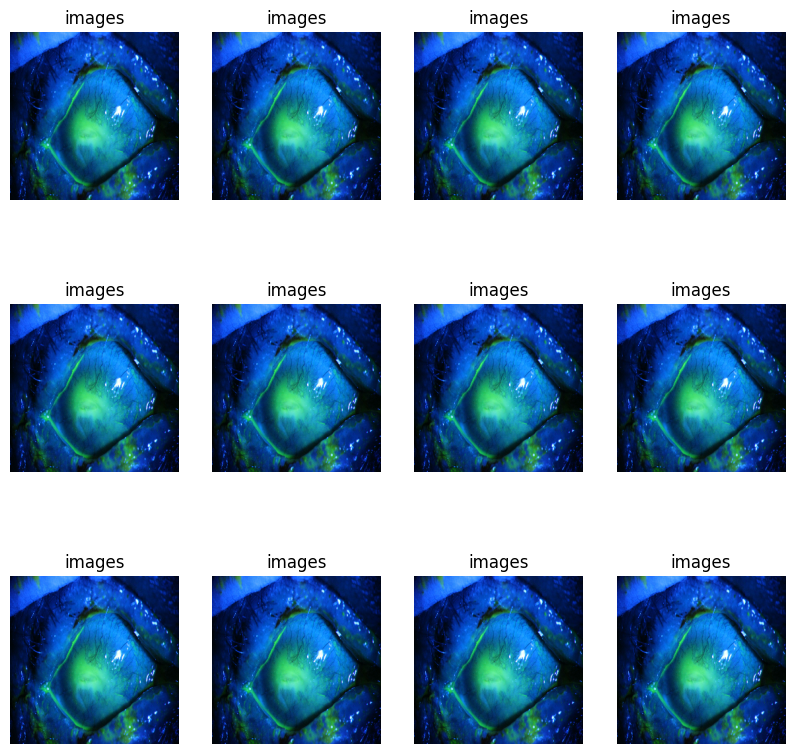

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")


In [ ]:
data1 = pd.read_csv('/content/dataset/labels.csv')
data1.head()

,name,category,type,grade
0,1.jpg,0,4,3
1,2.jpg,0,4,3
2,3.jpg,0,2,2
3,4.jpg,0,2,1
4,5.jpg,0,1,3


In [ ]:
data1.isnull().sum()

name        0
category    0
type        0
grade       0
dtype: int64

In [ ]:
Type_of_diseases = pd.unique(data1["type"])
print("The number of types of eye diseases {}".format(len(Type_of_diseases)))
Type_of_category = pd.unique(data1["category"])
print("The number of category of eye diseases {}".format(len(Type_of_category)))
Type_of_grades = pd.unique(data1["grade"])
print("the number of grade of eye disease {}".format(len(Type_of_grades)))

The number of types of eye diseases 5
The number of category of eye diseases 3
the number of grade of eye disease 5


In [ ]:
dic={}
for i in Type_of_diseases:
    dic[i]=data1['type'].value_counts()[i]
dic_category={}
for j in Type_of_category:
    dic_category[j]=data1['category'].value_counts()[j]
print(dic)
print(dic_category)
dic_grade={}
for k in Type_of_grades:
  dic_grade[k]=data1['grade'].value_counts()[k]
print(dic_grade)

{4: 548, 2: 40, 1: 78, 0: 36, 3: 10}
{0: 358, 1: 263, 2: 91}
{3: 273, 2: 203, 1: 98, 0: 36, 4: 102}


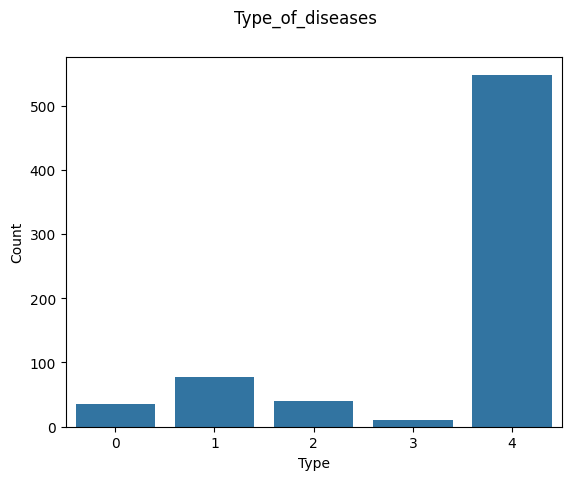

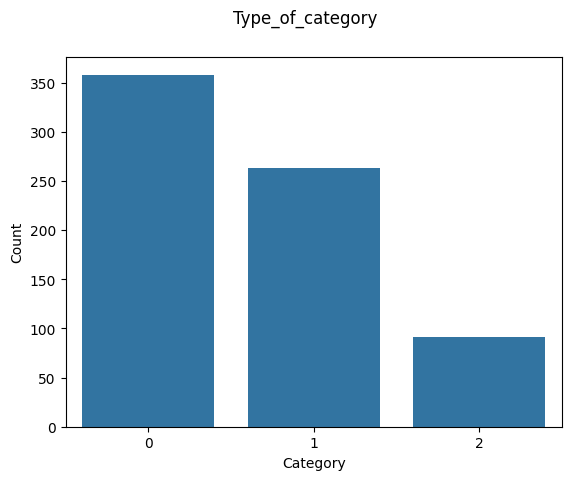

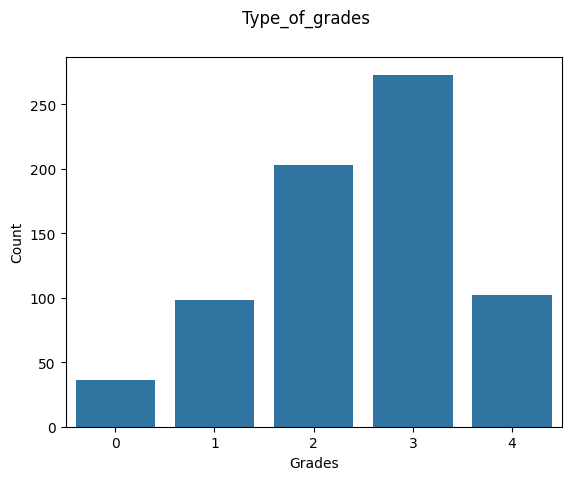

In [ ]:
sns.barplot(x = list(dic.keys()), y = list(dic.values()))
plt.suptitle("Type_of_diseases")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()
sns.barplot(x = list(dic_category.keys()), y = list(dic_category.values()))
plt.suptitle("Type_of_category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()
sns.barplot(x = list(dic_grade.keys()), y = list(dic_grade.values()))
plt.suptitle("Type_of_grades")
plt.xlabel("Grades")
plt.ylabel("Count")
plt.show()

In [ ]:
train_size = 0.8
len(dataset)*train_size

18.400000000000002

In [ ]:
train_ds = dataset.take(18)
len(train_ds)

18

In [ ]:
test_ds = dataset.skip(18)
len(test_ds)

5

In [ ]:
val_size = 0.1
len(dataset)*val_size

2.3000000000000003

In [ ]:
val_ds = test_ds.skip(2)
len(val_ds)

3

In [ ]:
test_ds = test_ds.skip(3)
len(test_ds)

2

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

18

In [ ]:
len(val_ds)

2

In [ ]:
len(test_ds)

3

In [ ]:
#Preprocessing
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [1]:
#data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

NameError: name 'tf' is not defined